# Step 1: Setup Environment


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm # This pacakge is used for svm classification
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)
from numpy import random
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import os
import pandas as pd

%load_ext tensorboard

c:\Users\Charlie\.virtualenvs\Model-mJPrqH2R\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# Step 2. Dataset preparation


In [2]:
import os
import numpy as np
from PIL import Image

def load_one_folder(folder_path, label, image_size):
    images = []
    for filename in os.listdir(folder_path):
        with Image.open(os.path.join(folder_path, filename)) as img:
            image = img.convert("RGB").resize(image_size)
            images.append(np.array(image, dtype=np.uint8))
    return images, [label] * len(images)

def load_all_folders(folder_path, label_names, image_size):
    X = []
    y = []
    for label in range(len(label_names)):
        X_temp, y_temp = load_one_folder(os.path.join(folder_path, label_names[label]), label, image_size)
        X += X_temp
        y += y_temp
    return np.array(X), np.array(y)


In [3]:
folder_path = "../Data/garbage-dataset/"
label_names = [filename for filename in os.listdir(folder_path)]

X, y = load_all_folders(folder_path, label_names, (400, 400))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Data Examples


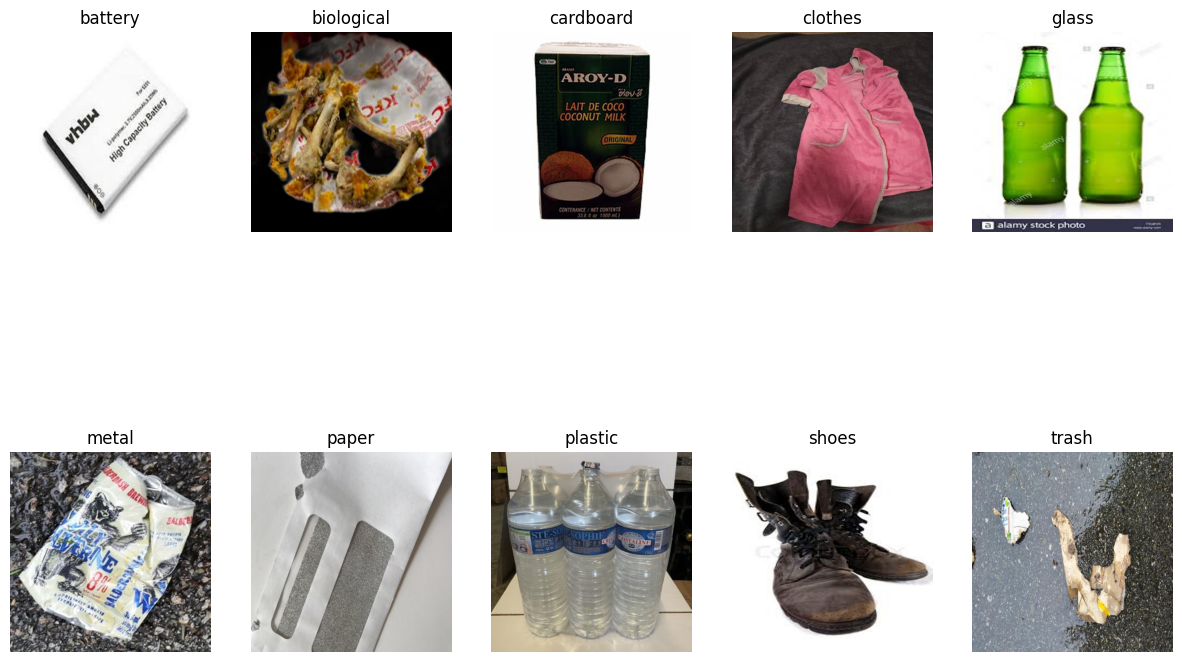

In [4]:
fig = plt.figure(figsize=(15, 10))

first_occurrence = {}
for index, (image, label) in enumerate(zip(X, y)):
    if label_names[label] not in first_occurrence:
        first_occurrence[label_names[label]] = image
    if len(first_occurrence) == len(label_names):
        break

for index, label_name in enumerate(label_names):
  axis = fig.add_subplot(2, 5, index + 1)
  axis.axis('off')
  axis.set_title(label_name)
  axis.imshow(first_occurrence[label_name])

## Original Dataset


In [ ]:
print(f'Original X Shape: {np.shape(X)}')
print(f'Original y Shape: {np.shape(y)}')

In [ ]:
from sklearn.decomposition import PCA

# Flatten the images if they are not already flattened
X_flattened = X.reshape((X_train.shape[0], -1))
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_flattened)

X_flattened = X.reshape((X_test.shape[0], -1))
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_test_reduced = pca.fit_transform(X_flattened)

# Print the new shape after PCA
print(f'Reduced X Train Shape: {np.shape(X_train_reduced)}')
print(f'Reduced X Test Shape: {np.shape(X_test_reduced)}')


# Step 3. Preprocessing Data


## (a) Raw


In [ ]:
X_train_Raw = np.reshape(X_train, (X_train.shape[0], -1)) / 255
X_test_Raw = np.reshape(X_test, (X_test.shape[0], -1)) / 255

## (b) LBP


In [ ]:
def get_LBP(image, numPoints=24, radius=8, eps=1e-7):
	lbp = feature.local_binary_pattern(image, numPoints,
		radius, method="uniform")
	(hist, _) = np.histogram(lbp.ravel(),
		bins=np.arange(0, numPoints + 3),
		range=(0, numPoints + 2))

	# normalize the histogram
	hist = hist.astype("float")
	hist /= (hist.sum() + eps)
	return hist

In [ ]:
X_train_LBP = np.array([get_LBP(image) for image in X_train])
X_test_LBP = np.array([get_LBP(image) for image in X_test])

## (c) HOG


In [ ]:
def get_HOG(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
		return feature.hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)

In [ ]:
X_train_HOG = np.array([get_HOG(image) for image in X_train])
X_test_HOG = np.array([get_HOG(image) for image in X_test])

Printing out the shapes of the processed dataset.


In [ ]:
print(f'Raw Training Data Shape: {np.shape(X_train_Raw)}')
print(f'LBP Training Data Shape: {np.shape(X_train_LBP)}')
print(f'HOG Training Data Shape: {np.shape(X_train_HOG)}')
print(f'Raw Testing Data Shape: {np.shape(X_test_Raw)}')
print(f'LBP Testing Data Shape: {np.shape(X_test_LBP)}')
print(f'HOG Testing Data Shape: {np.shape(X_test_HOG)}')

# Step 4. Models


## 4.1 SVM


In [ ]:
def train_SVM_model(X_train, y_train, X_test, y_test, param_grid):
  grid_search = GridSearchCV(svm.SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_
  accuracy = best_model.score(X_test, y_test)
  print("Best Hyperparameters:", best_params)
  print("Train set Accuracy: {:.3f}".format(best_model.score(X_train, y_train)))
  print("Test set Accuracy: {:.3f}".format(accuracy))
  return best_model, accuracy

### (a) Raw


In [ ]:
param_grid_SVM_Raw = {
  'C': [0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf', 'poly'],
  'gamma': ['scale', 'auto'],
}
# param_grid_SVM_Raw = {
#   'C': [10],
#   'kernel': ['poly'],
#   'gamma': ['auto'],
# }

SVM_Raw_model, SVM_Raw_accuracy = train_SVM_model(X_train_reduced, y_train, X_test_reduced, y_test, param_grid_SVM_Raw)

### (b) LBP


In [ ]:
param_grid_SVM_Raw = {
  'C': [100, 1000, 10000],
  'kernel': ['rbf', 'poly'],
  'gamma': ['scale', 'auto'],
}

SVM_LBP_model, SVM_LBP_accuracy = train_SVM_model(X_train_LBP, y_train, X_test_LBP, y_test, param_grid_SVM_Raw)

### (c) HOG


In [ ]:
param_grid_SVM_HOG = {
  'C': [0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf', 'poly'],
  'gamma': ['scale', 'auto'],
}

SVM_HOG_model, SVM_HOG_accuracy = train_SVM_model(X_train_HOG, y_train, X_test_HOG, y_test, param_grid_SVM_HOG)

## 4.2 ANN


In [ ]:
def train_ANN_model(model, X_train, y_train, X_test, y_test):
  model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

  X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
  history = model.fit(X_train_train, y_train_train, epochs=100, validation_data=(X_train_val, y_train_val))
  _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
  _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

  print("Train set Accuracy: {:.3f}".format(train_accuracy))
  print("Test set Accuracy: {:.3f}".format(test_accuracy))
  return model, test_accuracy, history

### (a) Raw


In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[2025]),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

ANN_Raw_model, ANN_Raw_accuracy, Raw_history = train_ANN_model(model, X_train_Raw, y_train, X_test_Raw, y_test)

### (b) LBP


In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[26]),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

ANN_LBP_model, ANN_LBP_accuracy, LBP_history = train_ANN_model(model, X_train_LBP, y_train, X_test_LBP, y_test)

### (c) HOG


In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=[576]),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

ANN_HOG_model, ANN_HOG_accuracy, HOG_history = train_ANN_model(model, X_train_HOG, y_train, X_test_HOG, y_test)

# Step 5. Evaluation


## (a) Models Accuracy Table


In [ ]:
accuracy_data = {
    '': ['SVM', 'ANN'],
    'Raw': [SVM_Raw_accuracy, ANN_Raw_accuracy],
    'LBP': [SVM_LBP_accuracy, ANN_LBP_accuracy],
    'HOG': [SVM_HOG_accuracy, ANN_HOG_accuracy],
}

print(pd.DataFrame(accuracy_data))

In [ ]:
def get_SVM_params(model):
  return np.sum(model.n_support_)

def get_ANN_params(model):
  trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
  non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
  return trainable_count + non_trainable_count

parameter_count = {
    '': ['SVM', 'ANN'],
    'Raw': [get_SVM_params(SVM_Raw_model), get_ANN_params(ANN_Raw_model)],
    'LBP': [get_SVM_params(SVM_LBP_model), get_ANN_params(ANN_LBP_model)],
    'HOG': [get_SVM_params(SVM_HOG_model), get_ANN_params(ANN_HOG_model)],
}

print(pd.DataFrame(parameter_count))


## (b) ANN History


In [ ]:
def evaluate_ANN_model(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show()

  plt.plot(history.history['loss'])
  plt.ylabel('cost')
  plt.xlabel('Epochs')
  plt.title("Cost/Loss Curve")
  plt.show()

In [ ]:
evaluate_ANN_model(HOG_history)

## (c) Confusion Matrix


In [ ]:
def evaluate_model(model, X_test, y_test):

  y_pred = [model.predict(X.reshape(1, -1)) for X in X_test]
  cm  = metrics.confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(model.score(X_test, y_test))
  plt.title(all_sample_title, size = 15);

In [ ]:
evaluate_model(SVM_HOG_model, X_test_HOG, y_test)